# Symbulate Documentation: Conditioning

<a id='contents'></a>

1. [**Introduction and installing Symbulate**](index.html)
1. [**Probability spaces**](probspace.html)
1. [**Simulation tools**](sim.html)
1. [**Random variables**](rv.html)
1. [**Commonly used probability models**](common.html)
1. [**Multiple random variables and joint distributions**](joint.html)
1. [**Conditioning**](#conditioning)
  1. [**Conditioning with |**](#pipe)
  1. [**Conditioning events**](#event)
  1. [**Conditioning on multiple events**](#combine)
  1. [**Conditioning on events in a probability space**](#outcome)
  1. [**Conditiong on the value of a continuous RV**](#continuous)
  1. [**Specifying a joint distribution via conditional and marginal distributions**](#conditional)
1. [**Random processes**](process.html)
1. [**Markov processes**](mc.html)

Instructions for downloading and installing Symbulate can be found [here](http://calpoly.edu/~dsun09/python.html).  During a session, be sure to import Symbulate using the following commands.

In [1]:
from symbulate import *
%matplotlib inline

<a id='conditioning'></a>

### Conditioning

We are often interested in the *conditional distribution* of some random variables *given* the values of other random variables.  For example, if $X$ represents height (inches) and $Y$ represents weight (pounds) for some population, then the conditional distribution of $X$ given $Y=150$ would represent the distribution of heights only for those in the population who weigh 150 pounds.

In principle, the conditional distribution of $X$ given $Y=y^*$ (where $y^*$ is a particular value, like 150 in the above example) can be simulated by (1) generating many $(x,y)$ pairs according to the joint distribution of $X$ and $Y$, (2) discarding all pairs for which $y\neq y^*$, and (3) summarizing the distribution of $x$ values for the pairs that remain.

<a id='pipe'></a>

### Conditioning with |

In Symbulate, the process of conditioning can be accomplished directly using the vertical "pipe" symbol | (read "given")

`(X | (Y == 150)).sim(10000)`

We illustrate conditioning first with a simple detailed example.

*Example.* A penny and a nickle are each flipped twice.  Let $X$ be the number of flips of the penny which land on heads, and $Y$ for the nickle.  What is the probability that the penny lands on heads exactly once, given that 3 heads are flipped in total?

First, $X$ and $Y$ will be independent, each with a Binomial(2, 0.5) distribution.

In [2]:
X, Y = RV(Binomial(2, 0.5) ** 2)

The following simulates many $X, Y$ pairs.  Note that unconditionally there are 9 possible values.

In [3]:
(X & Y).sim(10000).tabulate()

"(0, 0)",621
"(0, 1)",1219
"(0, 2)",645
"(1, 0)",1259
"(1, 1)",2529
"(1, 2)",1208
"(2, 0)",671
"(2, 1)",1227
"(2, 2)",621
Total,10000


However, we only want to consider pairs for which $X+Y$ is 3.  We accomplish this through conditioning as in the following code.  Note

* There are only two possible outcomes for which $X+Y=3$, (2 heads for penny, 1 for nickle; 1 head for penny, 2 for nickle), and so conditioning on $X+Y=3$ should return only these outcomes.
* Simulating with `.sim()` when conditioning generates the specified number of values for which the conditioning event is true (i.e. 10000 realizations of $X$ and $Y$ for which the $X+Y = 3$.)
* The conditioning event, `(X + Y == 3)`, is placed in parentheses
* The double equal sign `==` is used to check for equality

In [4]:
((X & Y) | (X + Y == 3)).sim(10000).tabulate()

"(1, 2)",5005
"(2, 1)",4995
Total,10000


The previous code illustrates the basic functionality of conditioning.  RVs and simulations with conditioning can be manipulated using the [simulation tools](sim.html) just as those without conditioning.  For example, to find and plot the conditional distribution of $X$ given $X+Y=3$:

In [5]:
x_given_y3 = (X | (X + Y == 3)).sim(10000)
x_given_y3.tabulate(normalize = True)

1,0.5036
2,0.4964
Total,1.0


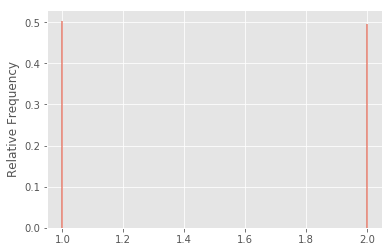

In [6]:
x_given_y3.plot()

<a id='event'></a>
[Back to contents](#contents)

### Conditioning events

Conditioning events must satisfy the following.

* **The conditioning event must be placed in parentheses.**
* The condition must involve at least one `RV`.  Remember that a function or transformation of `RV`s is also an `RV`.
* The conditioning event must involve a comparison operator: `==`, `>`, `<`, `>=`, `<=`

*Example.* Memoryless property of Exponential distributions.

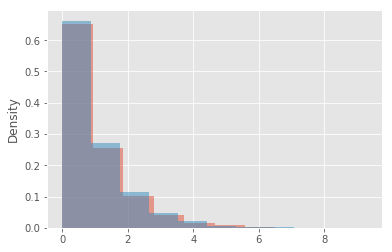

In [7]:
X = RV(Exponential(1))
(X - 5 | (X > 5)).sim(10000).plot()
RV(Exponential(1)).sim(10000).plot()

*Example.* Soccer teams X and Y score goals independently of each other, and the number of goals each team scores has a Poisson distribution with mean 1 for X and mean 2 for Y.  Find the expected number of goals that team X scores given that they score at least as many goals as team Y.

In [8]:
X, Y = RV(Poisson(1) * Poisson(2))
(X | (X >= Y)).sim(10000).mean()

1.6216999999999999

<a id='combine'></a>
[Back to contents](#contents)

### Conditioning on multiple events

Multiple events can be conditioned on using the logical operators

* `!` for not: (!A)
* `&` for and: (A & B) 
* `|` for or: (A | B).  **Caution: be sure to put parentheses around the conditioning events to avoid confusion between | for conditioning and | for or.**


*Example.* Times between successive earthquakes are independent each having an Exponential distribution with mean 0.5 hour.  Find the conditional distribution of the time (starting now) until the next earthquake occurs, given that exactly 1 earthquake occurs in the next 2 hours. 

Let $X, Y$ be the times between the first two quakes, so that X is the time of the first quake and $X+Y$ is the time of the second.  The event "exactly 1 quake in the next 2 hours" is equivalent to "the first quake occurs within 2 hours (X < 2) AND the second quake occurs after 2 hours (X + Y >2)".

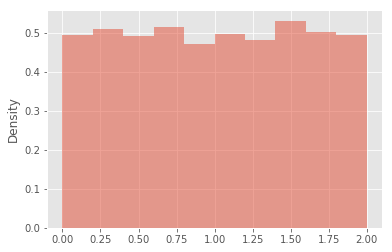

In [9]:
X, Y = RV(Exponential(scale = 0.5)**2)
(X | ((X < 2) & (X + Y > 2)) ).sim(10000).plot()

<a id='outcome'></a>
[Back to contents](#contents)

### Conditioning on events in a probability space

Symbulate allows for defining both ProbabilitySpaces and RVs.  Conditioning is only available for RV.  However, conditioning on events in a probability space can be accomplished by defining appropriate RVs and conditioning accordingly.  Note that RV is not required to take numerical values.

*Example.* Three cards are dealt without replacement from a standard deck of 52 cards.  What is the conditional probability that the third card is a heart given that the first two cards are hearts? (Note that the true conditional probability  is $11/50 = 0.22$.)

In [10]:
cards = ['clubs', 'diamonds', 'hearts', 'spades'] * 13
FirstCard, SecondCard, ThirdCard = RV(BoxModel(cards, size = 3, replace = False))

Note the FirstCard is a RV, but it takes non-numerical values ('clubs', etc). The following conditions on the FirstCard and SecondCard RVs taking the value 'hearts'

In [11]:
(FirstCard & SecondCard & ThirdCard | ((FirstCard == 'hearts') & (SecondCard == 'hearts')) ).sim(100000).tabulate()

"(('hearts', 'hearts'), 'clubs')",25974
"(('hearts', 'hearts'), 'diamonds')",25879
"(('hearts', 'hearts'), 'hearts')",22256
"(('hearts', 'hearts'), 'spades')",25891
Total,100000


<a id='continuous'></a>
[Back to contents](#contents)

### Conditioning on the value of a continuous RV

The probability that a continuous RV equals any particular value is 0, so care must be taken when conditioning on the value of a continuous RV.  If $X$ is continuous, conditioning on the event $X = x$, which has probability 0, can be interpreted in various ways.  The simplest approach is to translate conditioning on $X=x$ as conditioning on values for which $X$ is "close to" $x$.

*Example.* $X, Y, Z$ have a multivariate normal distribution with mean vector and covariance matrix below.  Find the conditional distribution of $X$ given $Y=1$.

We condition on $Y$ being within 0.01 of 1, using `(abs(Y - 1) < 0.01)`.  Note that this conditioning event has probability 0.005, so even though the probability is non-zero, it will still take some time to generate enough repetitions satisfying the condition.

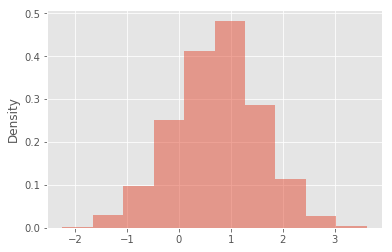

In [12]:
mu = [1, 2, 3]
Sigma = [[1, 1, -2],
        [1, 4, 0],
        [-2, 0, 9]]
X, Y, Z = RV(MultivariateNormal(mean = mu, cov = Sigma))

(X | (abs(Y - 1) < 0.01)).sim(1000).plot()

We can also find the conditional joint distribution of $X$ and $Y$ given $Y=1$.

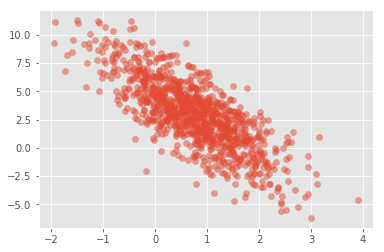

In [13]:
(X & Z | (abs(Y - 1) < 0.01)).sim(1000).plot()

$Y$ and $Z$ are independent

The correlation of y and z is -0.008


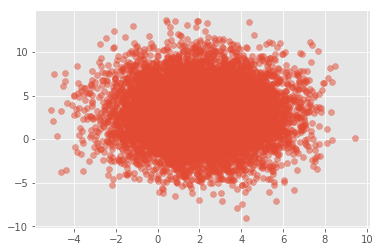

In [14]:
yz = (Y & Z).sim(10000)
yz.plot()
print('The correlation of y and z is {:.3f}'.format(yz.corr()))

But $Y$ and $Z$ are not conditionally independent given $X = 2$

The correlation of y and z given x equals 2 is 0.527


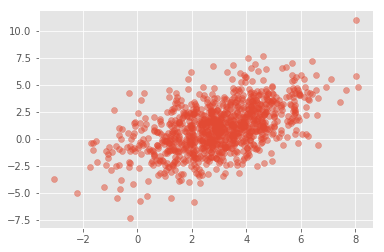

In [15]:
yz_given_x = (Y & Z | (abs(X - 2) < 0.01)).sim(1000)
yz_given_x.plot()
print('The correlation of y and z given x equals 2 is {:.3f}'.format(yz_given_x.corr()))

<a id='conditional'></a>
[Back to contents](#contents)

### Specifying a joint distribution via conditional distribution and marginal distributions

The joint distribution fully specifies the conditional and marginal distributions, and so conditioning can be used when the joint distribution is specified.  However, in many situations we specify a joint distribution indirectly by specifying appropriate conditional and marginal distributions.  Such a specification can be made in Symbulate using a custom [`ProbabilitySpace`](probspace.html#probability_space).

*Example.* Suppose that $X$ has a Uniform(0,1) distribution and that, given $X=x$, $Y$ has a Binomial(10, $x$) distribution.

First define the joint distribution of $X$ and $Y$ using a custom probability space.

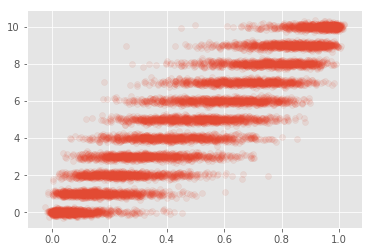

In [16]:
def binomial_given_uniform():
    x = Uniform(0,1).draw()
    y = Binomial(10, x).draw()
    return x, y

X, Y = RV(ProbabilitySpace(binomial_given_uniform))

(X & Y).sim(10000).plot(jitter = True, alpha = 0.1)

Use the joint distribution to simulate the conditional distribution of $Y$ given $X=0.3$ (and compare to Binomial(10, 0.3)).

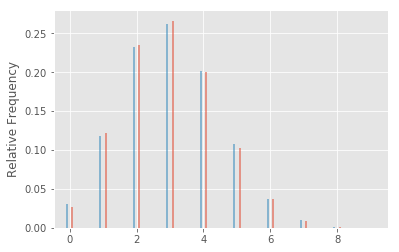

In [17]:
(Y | (abs(X - 0.3) < 0.01) ).sim(10000).plot(jitter = True)
RV(Binomial(10, 0.3)).sim(10000).plot(jitter = True)

Simulate the conditional distribution of $X$ given $Y=3$.

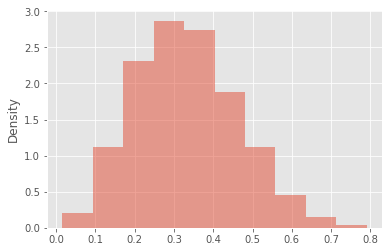

In [18]:
(X | (Y == 3) ).sim(10000).plot()

[Back to contents](#contents)